<a href="https://colab.research.google.com/github/Ajogeorge29/100-Days-of-Python_in_MedImages/blob/main/STSR_Challenge_02Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1- cloning the baseline

In [3]:
# Clone the entire STSR Challenge repo
!git clone https://github.com/ricoleehduu/STSR-Challenge.git


fatal: destination path 'STSR-Challenge' already exists and is not an empty directory.


In [4]:
!ls "STSR-Challenge/STSR-2025/baseline"


STSR-Task1-Baseline  STSR-Task2-Baseline


In [5]:
# Navigate to Task 2: CBCT-IOS Registration baseline
%cd STSR-Challenge/STSR-2025/baseline/STSR-Task2-Baseline

/content/STSR-Challenge/STSR-2025/baseline/STSR-Task2-Baseline


2- Install Libraries

In [6]:
# Core libraries
!pip install open3d pycpd scikit-learn pandas tqdm scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


 3: Mount Google Drive & Access Dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
import os
DATASET_DIR = "/content/drive/MyDrive/DiceMed Pvt Ltd Company/DATASETS/MICCAI-Challenge-STSR2025-Task2"
os.listdir(DATASET_DIR)

['Train-Labeled', 'Train-Unlabeled', 'Validation']

SR-*Task2*
STSR-Task2/
├── Train-Labeled/
│   ├── 001/
│   │   ├── CBCT.nii.gz
│   │   ├── upper.stl
│   │   ├── lower.stl
│   │   ├── upper_gt.npy
│   │   └── lower_gt.npy
│   ├── 002/
│   └── ...
├── Train-Unlabeled/
│   └── ...
└── Validation/
    └── ...


In [12]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 13.7 MB/s eta 0:00:00


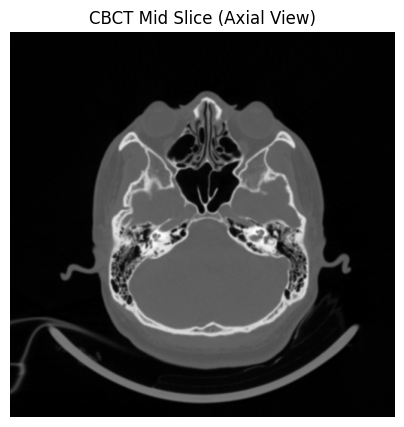

In [13]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
case_path = "/content/drive/MyDrive/DiceMed Pvt Ltd Company/DATASETS/STS2025Task002/010"


# Load CBCT volume
cbct_image = sitk.ReadImage(os.path.join(case_path, "CBCT.nii.gz"))
cbct_array = sitk.GetArrayFromImage(cbct_image)  # shape: (slices, H, W)

# Show middle axial slice
plt.figure(figsize=(5, 5))
plt.imshow(cbct_array[cbct_array.shape[0] // 2], cmap="gray")
plt.title("CBCT Mid Slice (Axial View)")
plt.axis("off")
plt.show()


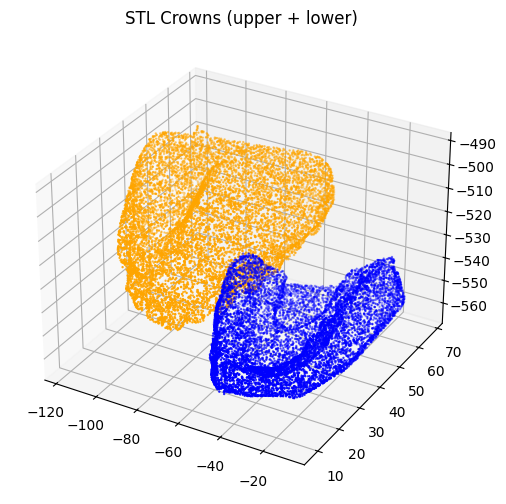

In [14]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
case_path = "/content/drive/MyDrive/DiceMed Pvt Ltd Company/DATASETS/STS2025Task002/010"

# Load STL
upper_stl = o3d.io.read_triangle_mesh(os.path.join(case_path, "upper.stl"))
lower_stl = o3d.io.read_triangle_mesh(os.path.join(case_path, "lower.stl"))

# Assign color
upper_stl.paint_uniform_color([1, 0.706, 0])
lower_stl.paint_uniform_color([0.2, 0.6, 1])

# Convert to point clouds (for Plotly)
upper_pcd = upper_stl.sample_points_uniformly(number_of_points=10000)
lower_pcd = lower_stl.sample_points_uniformly(number_of_points=10000)

# Extract numpy points
up = np.asarray(upper_pcd.points)
low = np.asarray(lower_pcd.points)

# Plot using matplotlib
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(up[:, 0], up[:, 1], up[:, 2], c='orange', s=0.5)
ax.scatter(low[:, 0], low[:, 1], low[:, 2], c='blue', s=0.5)
ax.set_title("STL Crowns (upper + lower)")
plt.show()


5: Apply Ground Truth .npy Transformation

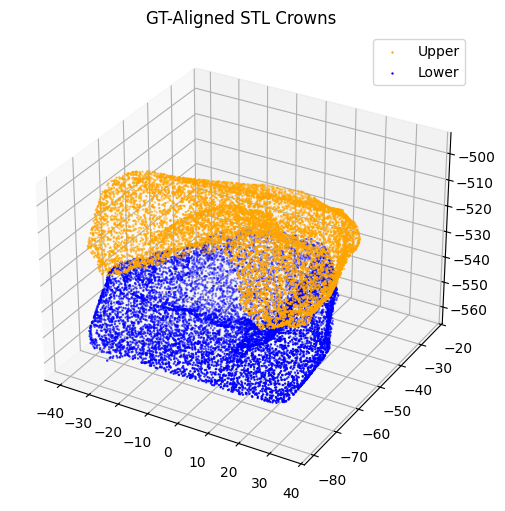

In [15]:
import numpy as np
import open3d as o3d
import os
import matplotlib.pyplot as plt

# Set folder where .stl and .npy are located
case_path = "/content/drive/MyDrive/DiceMed Pvt Ltd Company/DATASETS/STS2025Task002/010"

# Load STL
upper = o3d.io.read_triangle_mesh(os.path.join(case_path, "upper.stl"))
lower = o3d.io.read_triangle_mesh(os.path.join(case_path, "lower.stl"))

# Load .npy transformation matrices
upper_T = np.load(os.path.join(case_path, "upper_gt.npy"))
lower_T = np.load(os.path.join(case_path, "lower_gt.npy"))

# Apply transformation function
def transform_mesh(mesh, T):
    points = np.asarray(mesh.vertices)
    ones = np.ones((points.shape[0], 1))
    points_h = np.hstack([points, ones])
    transformed = (T @ points_h.T).T[:, :3]
    mesh.vertices = o3d.utility.Vector3dVector(transformed)
    return mesh

# Apply
upper_t = transform_mesh(upper, upper_T)
lower_t = transform_mesh(lower, lower_T)

# Sample points to visualize
upper_pts = np.asarray(upper_t.sample_points_uniformly(10000).points)
lower_pts = np.asarray(lower_t.sample_points_uniformly(10000).points)

# Plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(upper_pts[:, 0], upper_pts[:, 1], upper_pts[:, 2], c='orange', s=0.5, label="Upper")
ax.scatter(lower_pts[:, 0], lower_pts[:, 1], lower_pts[:, 2], c='blue', s=0.5, label="Lower")
ax.set_title("GT-Aligned STL Crowns")
plt.legend()
plt.show()


Batch Preprocessing Script

In [ ]:
import os
import open3d as o3d
import numpy as np
from tqdm import tqdm

# Define paths
images_root = "/content/drive/MyDrive/DiceMed Pvt Ltd Company/DATASETS/MICCAI-Challenge-STSR2025-Task2/Train-Labeled/Images"
labels_root = "/content/drive/MyDrive/DiceMed Pvt Ltd Company/DATASETS/MICCAI-Challenge-STSR2025-Task2/Train-Labeled/Labels"
output_root = "/content/drive/MyDrive/DiceMed Pvt Ltd Company/DATASETS/Processed-STSR-Task2"

os.makedirs(output_root, exist_ok=True)

# Helper: apply transformation
def transform_mesh(mesh, T):
    points = np.asarray(mesh.vertices)
    points_h = np.hstack([points, np.ones((points.shape[0], 1))])
    transformed = (T @ points_h.T).T[:, :3]
    mesh.vertices = o3d.utility.Vector3dVector(transformed)
    return mesh

# Iterate through all cases
for case_id in tqdm(sorted(os.listdir(images_root))):
    case_img_path = os.path.join(images_root, case_id)
    case_lbl_path = os.path.join(labels_root, case_id)

    # Skip non-directories
    if not os.path.isdir(case_img_path) or not os.path.isdir(case_lbl_path):
        continue

    # Prepare output folder
    out_case_path = os.path.join(output_root, case_id)
    os.makedirs(out_case_path, exist_ok=True)

    # Copy CBCT volume
    cbct_in = os.path.join(case_img_path, "CBCT.nii.gz")
    cbct_out = os.path.join(out_case_path, "target_CBCT.nii.gz")
    os.system(f"cp '{cbct_in}' '{cbct_out}'")

    # Process upper STL
    upper_stl_path = os.path.join(case_img_path, "upper.stl")
    upper_gt_path = os.path.join(case_lbl_path, "upper_gt.npy")

    upper = o3d.io.read_triangle_mesh(upper_stl_path)
    upper_T = np.load(upper_gt_path)
    upper_aligned = transform_mesh(upper, upper_T)

    o3d.io.write_triangle_mesh(os.path.join(out_case_path, "source_upper_raw.ply"), upper)
    o3d.io.write_triangle_mesh(os.path.join(out_case_path, "source_upper_aligned.ply"), upper_aligned)
    np.save(os.path.join(out_case_path, "gt_upper.npy"), upper_T)

    # Process lower STL
    lower_stl_path = os.path.join(case_img_path, "lower.stl")
    lower_gt_path = os.path.join(case_lbl_path, "lower_gt.npy")

    lower = o3d.io.read_triangle_mesh(lower_stl_path)
    lower_T = np.load(lower_gt_path)
    lower_aligned = transform_mesh(lower, lower_T)

    o3d.io.write_triangle_mesh(os.path.join(out_case_path, "source_lower_raw.ply"), lower)
    o3d.io.write_triangle_mesh(os.path.join(out_case_path, "source_lower_aligned.ply"), lower_aligned)
    np.save(os.path.join(out_case_path, "gt_lower.npy"), lower_T)


 93%|█████████▎| 28/30 [07:24<00:23, 11.51s/it]